In [1]:
from src import PINNViga
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

EI = 1.0
q = 1.0 
L = 1.0

In [8]:
## VIGA BIAPOIADA

apoio_esq = [1, 1, 0]
apoio_dir = [0, 1, 0]

x, u, xt = PINNViga.run_model(apoio_esq, apoio_dir, EI, q, L, num_epochs=2000, pde_weight=1, bc_weight=10)

Epoch 0, Loss: 89.831977844238, PDE Loss: 89.820579528809, BC Loss: 0.001140060020
Epoch 200, Loss: 0.626410186291, PDE Loss: 0.231082364917, BC Loss: 0.039532780647
Epoch 400, Loss: 0.256889641285, PDE Loss: 0.128012970090, BC Loss: 0.012887665071
Epoch 600, Loss: 0.006445750128, PDE Loss: 0.005907928105, BC Loss: 0.000053782205
Epoch 800, Loss: 0.002437267685, PDE Loss: 0.002353346441, BC Loss: 0.000008392119
Epoch 1000, Loss: 0.001124163042, PDE Loss: 0.001100786962, BC Loss: 0.000002337612
Epoch 1200, Loss: 0.001106745913, PDE Loss: 0.001075216918, BC Loss: 0.000003152903
Epoch 1400, Loss: 0.000505824282, PDE Loss: 0.000503288058, BC Loss: 0.000000253625
Epoch 1600, Loss: 0.000407573418, PDE Loss: 0.000406371255, BC Loss: 0.000000120217
Epoch 1800, Loss: 0.000359195459, PDE Loss: 0.000358544174, BC Loss: 0.000000065128
Epoch 2000, Loss: 0.000314203062, PDE Loss: 0.000313785189, BC Loss: 0.000000041787


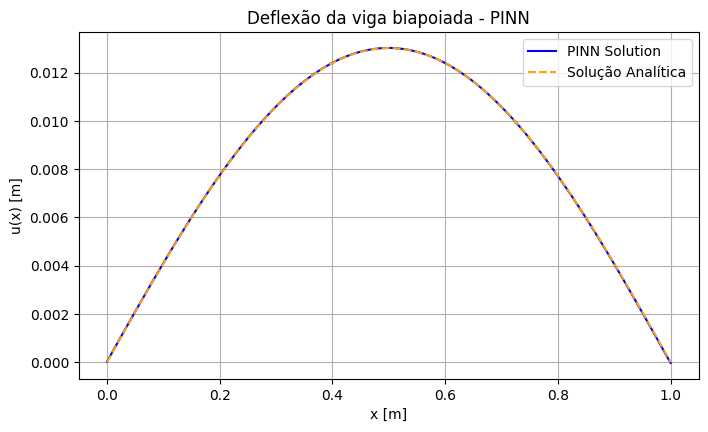

In [9]:
def y_calc(x_val): 
    return (q * x_val / (24 * EI)) * (L**3 - 2 * L * x_val**2 + x_val**3)

plt.figure(figsize=(8, 4.5))
plt.plot(x, u, label='PINN Solution', color='blue')
plt.plot(x, y_calc(x), label='Solução Analítica', linestyle='dashed', color='orange')
plt.title("Deflexão da viga biapoiada - PINN")
plt.xlabel("x [m]")
plt.ylabel("u(x) [m]")
plt.grid(True)
plt.legend()
plt.show()

In [5]:
## VIGA ENGASTADA

apoio_esq = [1, 1, 1]
apoio_dir = [0, 0, 0]

x2, u2, xt2 = PINNViga.run_model(apoio_esq, apoio_dir, EI, q, L, num_epochs=5000, pde_weight=1.0, bc_weight=10.0)

Epoch 0, Loss: 0.826173, PDE Loss: 0.555946, BC Loss: 0.027023
Epoch 500, Loss: 0.000027, PDE Loss: 0.000027, BC Loss: 0.000000
Epoch 1000, Loss: 0.000023, PDE Loss: 0.000023, BC Loss: 0.000000
Epoch 1500, Loss: 0.000021, PDE Loss: 0.000021, BC Loss: 0.000000
Epoch 2000, Loss: 0.000194, PDE Loss: 0.000039, BC Loss: 0.000016
Epoch 2500, Loss: 0.000103, PDE Loss: 0.000063, BC Loss: 0.000004
Epoch 3000, Loss: 0.000285, PDE Loss: 0.000045, BC Loss: 0.000024
Epoch 3500, Loss: 0.000014, PDE Loss: 0.000014, BC Loss: 0.000000
Epoch 4000, Loss: 0.000013, PDE Loss: 0.000013, BC Loss: 0.000000
Epoch 4500, Loss: 0.000095, PDE Loss: 0.000058, BC Loss: 0.000004
Epoch 5000, Loss: 0.000010, PDE Loss: 0.000010, BC Loss: 0.000000


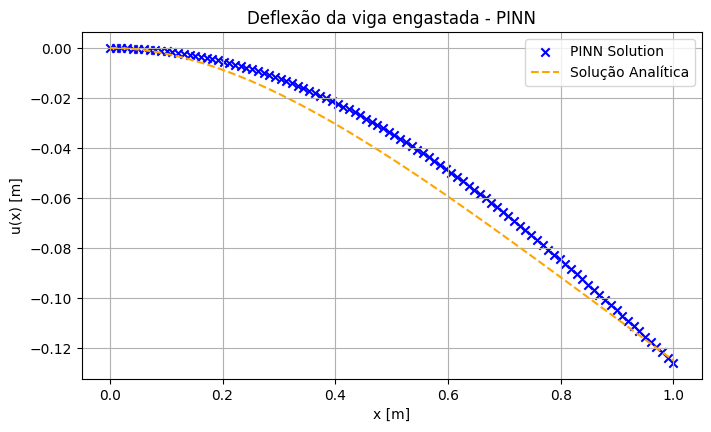

In [6]:
def y_calc2(x_val): 
    # return -(q / (24 * EI)) * (x_val**4 - 4 * (L ** 3 )* x_val + 3 * L**4)
    return -(q / (24 * EI)) * (x_val**4 - 4 * L * x_val**3 + 6 * L**2 * x_val**2)

plt.figure(figsize=(8, 4.5))
plt.scatter(x2, u2, label='PINN Solution', color='blue', marker = 'x')
plt.plot(x2, y_calc2(x2), label='Solução Analítica', linestyle='dashed', color='orange')
plt.title("Deflexão da viga engastada - PINN")
plt.xlabel("x [m]")
plt.ylabel("u(x) [m]")
plt.grid(True)
plt.legend()
plt.show()

In [7]:
## VIGA BIAPOIADA

apoio_esq = [1, 1, 0]
apoio_dir = [0, 1, 0]

x, u, xt = PINNViga.run_model_adaptive(apoio_esq, apoio_dir, EI, q, L, num_epochs=5000)

Epoch 0, Total Loss: 0.720126, PDE Loss: 0.688285, BC Loss: 0.031841, PDE Weight: 0.9990, BC Weight: 0.9990
Epoch 500, Total Loss: 0.000019, PDE Loss: 0.000019, BC Loss: 0.000000, PDE Weight: 0.9728, BC Weight: 0.9152
Epoch 1000, Total Loss: 0.000015, PDE Loss: 0.000016, BC Loss: 0.000000, PDE Weight: 0.9725, BC Weight: 0.9152
Epoch 1500, Total Loss: 0.000014, PDE Loss: 0.000014, BC Loss: 0.000000, PDE Weight: 0.9719, BC Weight: 0.9138
Epoch 2000, Total Loss: 0.000010, PDE Loss: 0.000011, BC Loss: 0.000000, PDE Weight: 0.9711, BC Weight: 0.9110
Epoch 2500, Total Loss: 0.000009, PDE Loss: 0.000009, BC Loss: 0.000000, PDE Weight: 0.9703, BC Weight: 0.9078
Epoch 3000, Total Loss: 0.000008, PDE Loss: 0.000008, BC Loss: 0.000000, PDE Weight: 0.9686, BC Weight: 0.9037
Epoch 3500, Total Loss: 0.000013, PDE Loss: 0.000007, BC Loss: 0.000006, PDE Weight: 0.9668, BC Weight: 0.8988
Epoch 4000, Total Loss: 0.000129, PDE Loss: 0.000010, BC Loss: 0.000134, PDE Weight: 0.9645, BC Weight: 0.8893
Epoch

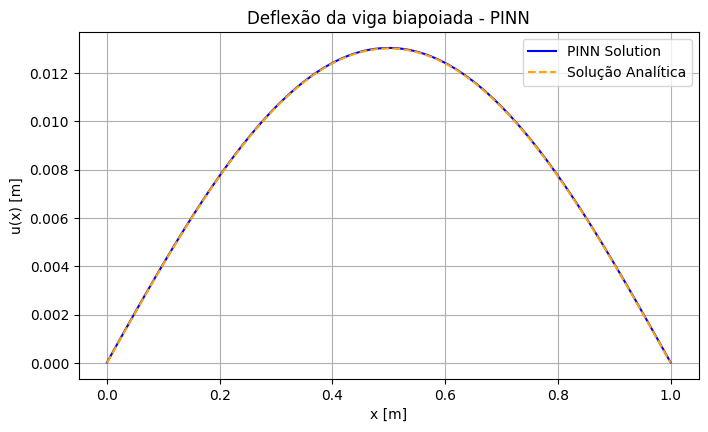

In [8]:
def y_calc(x_val): 
    return (q * x_val / (24 * EI)) * (L**3 - 2 * L * x_val**2 + x_val**3)

plt.figure(figsize=(8, 4.5))
plt.plot(x, u, label='PINN Solution', color='blue')
plt.plot(x, y_calc(x), label='Solução Analítica', linestyle='dashed', color='orange')
plt.title("Deflexão da viga biapoiada - PINN")
plt.xlabel("x [m]")
plt.ylabel("u(x) [m]")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
## VIGA ENGASTADA

apoio_esq = [1, 1, 1]
apoio_dir = [0, 0, 0]

x2, u2, xt2 = PINNViga.run_model_adaptive(apoio_esq, apoio_dir, EI, q, L, num_epochs=5000)

Epoch 0, Total Loss: 0.541715, PDE Loss: 0.531573, BC Loss: 0.010142, PDE Weight: 0.9990, BC Weight: 0.9990
Epoch 500, Total Loss: 0.000166, PDE Loss: 0.000171, BC Loss: 0.000001, PDE Weight: 0.9686, BC Weight: 0.9363
Epoch 1000, Total Loss: 0.000077, PDE Loss: 0.000080, BC Loss: 0.000000, PDE Weight: 0.9638, BC Weight: 0.9362
Epoch 1500, Total Loss: 0.000039, PDE Loss: 0.000041, BC Loss: 0.000000, PDE Weight: 0.9600, BC Weight: 0.9360
Epoch 2000, Total Loss: 0.000022, PDE Loss: 0.000023, BC Loss: 0.000000, PDE Weight: 0.9563, BC Weight: 0.9359
Epoch 2500, Total Loss: 0.000685, PDE Loss: 0.000708, BC Loss: 0.000012, PDE Weight: 0.9512, BC Weight: 0.9356
Epoch 3000, Total Loss: 0.000011, PDE Loss: 0.000011, BC Loss: 0.000000, PDE Weight: 0.9457, BC Weight: 0.9353
Epoch 3500, Total Loss: 0.000019, PDE Loss: 0.000020, BC Loss: 0.000000, PDE Weight: 0.9400, BC Weight: 0.9350
Epoch 4000, Total Loss: 0.000006, PDE Loss: 0.000006, BC Loss: 0.000000, PDE Weight: 0.9338, BC Weight: 0.9346
Epoch

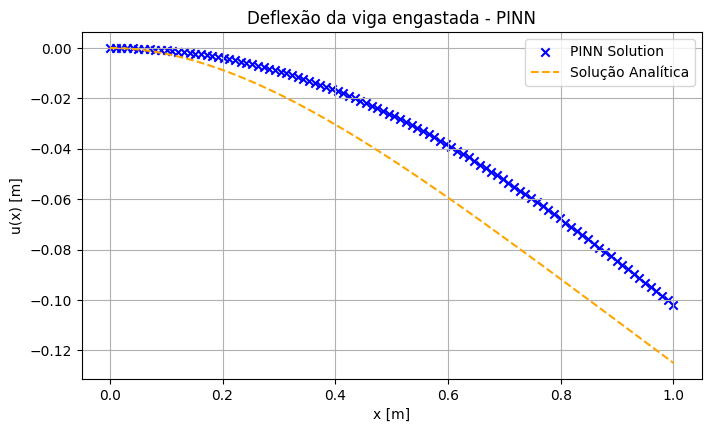

In [10]:
def y_calc2(x_val): 
    # return -(q / (24 * EI)) * (x_val**4 - 4 * (L ** 3 )* x_val + 3 * L**4)
    return -(q / (24 * EI)) * (x_val**4 - 4 * L * x_val**3 + 6 * L**2 * x_val**2)

plt.figure(figsize=(8, 4.5))
plt.scatter(x2, u2, label='PINN Solution', color='blue', marker = 'x')
plt.plot(x2, y_calc2(x2), label='Solução Analítica', linestyle='dashed', color='orange')
plt.title("Deflexão da viga engastada - PINN")
plt.xlabel("x [m]")
plt.ylabel("u(x) [m]")
plt.grid(True)
plt.legend()
plt.show()